In [1]:
!pip install wandb

In [2]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from time import time
from matplotlib import image
from torchvision import transforms, datasets, models
from efficientnet_pytorch import EfficientNet
import wandb
import time
import timm
import torch
import torch.utils.data as data

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
wandb.init(project='img-classification', entity='zeus0007')

wandb: Currently logged in as: zeus0007 (use `wandb login --relogin` to force relogin)

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



In [4]:
train_data  = pd.read_csv(r'/opt/ml/input/data/train/new_train.csv')

In [5]:
train_data

,Full Path,NewClass,-,Class Compare,Original Class,-.1,Mask,Gender,Age,-.2,ImageName,Gender.1,Age.1,ID
0,/opt/ml/input/data/train/images/000001_female_...,10,NaN,True,10,NaN,1,1,1,NaN,incorrect_mask.jpg,female,45,1
1,/opt/ml/input/data/train/images/000001_female_...,4,NaN,True,4,NaN,0,1,1,NaN,mask1.jpg,female,45,1
2,/opt/ml/input/data/train/images/000001_female_...,4,NaN,True,4,NaN,0,1,1,NaN,mask2.jpg,female,45,1
3,/opt/ml/input/data/train/images/000001_female_...,4,NaN,True,4,NaN,0,1,1,NaN,mask3.jpg,female,45,1
4,/opt/ml/input/data/train/images/000001_female_...,4,NaN,True,4,NaN,0,1,1,NaN,mask4.jpg,female,45,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18895,/opt/ml/input/data/train/images/006959_male_As...,0,NaN,True,0,NaN,0,0,0,NaN,mask2.jpg,male,19,6959
18896,/opt/ml/input/data/train/images/006959_male_As...,0,NaN,True,0,NaN,0,0,0,NaN,mask3.jpg,male,19,6959
18897,/opt/ml/input/data/train/images/006959_male_As...,0,NaN,True,0,NaN,0,0,0,NaN,mask4.jpg,male,19,6959
18898,/opt/ml/input/data/train/images/006959_male_As...,0,NaN,True,0,NaN,0,0,0,NaN,mask5.jpg,male,19,6959


## Dataset 형성

In [6]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
class imgDataset(Dataset):
    def __init__(self, csv_path):
        self.main_path = csv_path
        self.total_data = pd.read_csv(self.main_path + '/' + 'new_train.csv')
        #self.image_folder = (self.main_path + '/' + 'images')
        self.transform = transforms.Compose([
                                            transforms.CenterCrop(384),
                                            transforms.Resize(256),
                                            transforms.ToTensor(),
                                             
                                            transforms.Normalize(mean = [0.5,0.5,0.5],
                                                                 std =[0.5,0.5,0.5])])#384 384로 crop을 하고, 그런 후 256으로 resize
    def __getitem__(self,index):
        image = Image.open(self.total_data.iloc[index]['Full Path'])
        image = self.transform(image)
        class_num = self.total_data.iloc[index]['NewClass']
        gender = self.total_data.iloc[index]['Gender'] #female 은 1 male은 0
        mask = self.total_data.iloc[index]['Mask']# noraml이 1, mask가 0, 이상한 착용이 2
        age = self.total_data.iloc[index]['Age']#1이30~60, 0이 30 이하, 2가 60 이상
        return gender, mask, age, class_num, image
    def __len__(self):
        return self.total_data.shape[0]

In [7]:
class_img = imgDataset(r'/opt/ml/input/data/train')

In [8]:
len(class_img)

18900

## Train Valid 분리

In [9]:
train_len = int(len(class_img) * 0.8)
print(train_len)
val_len = len(class_img) - train_len
print(val_len)
from torch.utils.data.dataset import random_split
train_dataset, val_dataset = random_split(class_img, [train_len,val_len])

15120
3780


## Dataloader 형성

In [10]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset = train_dataset, batch_size=64, shuffle = True, drop_last=True)    #통상 첨에 시작할때 batch는 64에서 128로 잡는다  
val_loader = DataLoader(dataset = val_dataset, batch_size=64, shuffle = True, drop_last=True)

## Pretrained 모델(다중 택일) + MLP 형성

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.pretrained = models.resnet152(pretrained=True)
        #last_layer_features = self.pretrained.fc.in_features
        ### strip the last layer
        self.backbone = torch.nn.Sequential(*list(self.pretrained.children())[:-1])#self.backbone은 이제 resnet에서 convolution layer만 있는 상태이다!!
        #self.gender = nn.Linear(2048, 2)
        self.gender = nn.Sequential(nn.Linear(2048,500),
                                            nn.Linear(500,100),
                                           nn.Linear(100,2),
                                   nn.Softmax())
        self.mask = nn.Sequential(nn.Linear(2048,500),
                                            nn.Linear(500,100),
                                           nn.Linear(100,3),
                                 nn.Softmax())
        self.age = nn.Sequential(nn.Linear(2048,500),
                                            nn.Linear(500,100),
                                           nn.Linear(100,3),
                                nn.Softmax())
    def forward(self, x):
        shared = self.backbone(x).squeeze()
        gender = self.gender(shared)
        mask = self.mask(shared)
        age = self.age(shared)
        
        return gender, mask, age
        #x = torch.randn([1,3,224,224])
        #output = self.backbone(x)
        #print(output.shape)
        #print(last_layer_features)


In [13]:
model = Model().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)

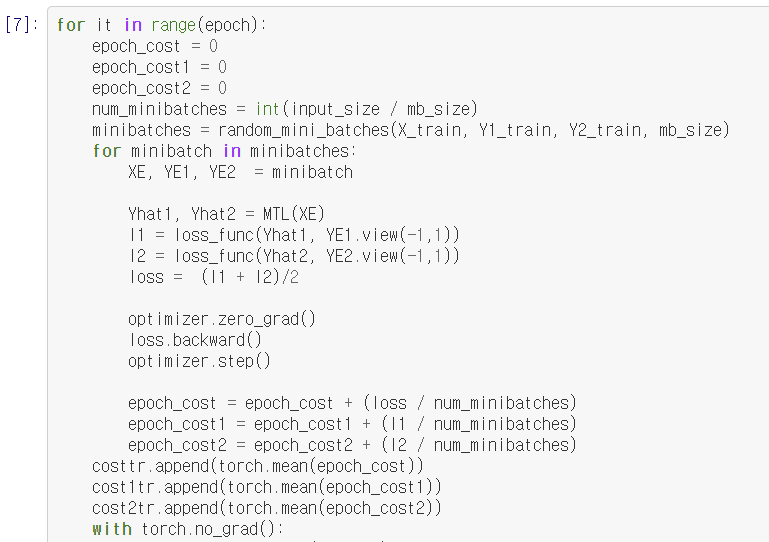

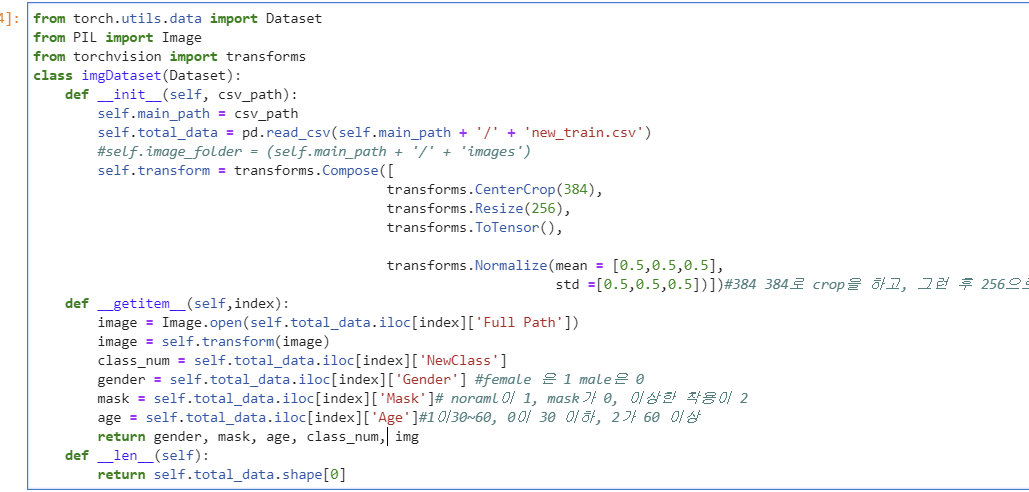

In [14]:
def Train_and_Valid_check(model, model_name):
    from tqdm.notebook import tqdm
    MODEL_PATH ="multi_layer_saved"
    
    num_epochs = 10
    #start_time = time.time()

    for epoch in range(num_epochs):
        """ Training Phase """
        model.train()

        running_loss = 0.
        running_corrects = 0

        # load a batch data of images
        for gender, mask, age, class_num, img in tqdm(train_loader):
            #inputs = inputs.to(device)
            gender = gender.to(device)
            mask = mask.to(device)
            age = age.to(device)
            class_num = class_num.to(device)
            img = img.to(device)#img가 

            # forward inputs and get output
            optimizer.zero_grad()
            gender_out, mask_out, age_out = model(img)
            #outputs = model(img)
            _, gender_preds = torch.max(gender_out, 1)
            _, mask_preds = torch.max(mask_out,1)
            _, age_preds = torch.max(age_out,1)
            #loss = loss_func(outputs, labels)
            gender_loss = loss_func(gender_out,gender)
            mask_loss = loss_func(mask_out, mask)
            age_loss = loss_func(age_out, age)
            # get loss value and update the network weights
            
            #total_loss = (gender_loss + mask_loss + age_loss)/3
            total_loss = gender_loss * 0.2 + mask_loss * 0.2 + age_loss * 0.6
            total_loss.backward()
            optimizer.step()
            
            #loss.backward()
            #optimizer.step()
            #print(img.size(0))
            preds = mask_preds* 6 + gender_preds * 3 + age_preds
            running_loss += total_loss.item() * img.size(0)#64개 만큼의 loss가 나온다 
            # loss.item() 으로 손실이 갖고 있는 스칼라 값을 가져올 수 있습니다.
        #딕셔너리.items()와 다른것 주의!!
            running_corrects += torch.sum(preds == class_num.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset) * 100.
        print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% '.format(epoch, epoch_loss, epoch_acc))


        model.eval()

        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0

            for gender, mask, age, class_num, img in tqdm(val_loader):#얼마나 진행됐고 얼마나 남았는지 알려줌
                gender = gender.to(device)
                mask = mask.to(device)
                age = age.to(device)
                class_num = class_num.to(device)
                img = img.to(device)#img가 

                #outputs = model(inputs)
                gender_out, mask_out, age_out = model(img)
                #_, preds = torch.max(outputs, 1)
                _, gender_preds = torch.max(gender_out, 1)
                _, mask_preds = torch.max(mask_out,1)
                _, age_preds = torch.max(age_out,1)
                #loss = loss_func(outputs, labels)
                gender_loss = loss_func(gender_out,gender)
                mask_loss = loss_func(mask_out, mask)
                age_loss = loss_func(age_out, age)
            # get loss value and update the network weights
            
                total_loss = (gender_loss + mask_loss + age_loss)/3

                running_loss += total_loss.item() * img.size(0)
                preds = mask_preds* 6 + gender_preds * 3 + age_preds
                running_corrects += torch.sum(preds == class_num.data)

            epoch_loss = running_loss / len(val_dataset)
            epoch_acc = running_corrects / len(val_dataset) * 100.
            #wandb.log({"val_acc":epoch_acc, "val_loss":epoch_loss})
            wandb.log({"val_acc":epoch_acc, "val_loss":epoch_loss})
            print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% '.format(epoch, epoch_loss, epoch_acc))
        if not os.path.exists(MODEL_PATH):
            os.makedirs(MODEL_PATH)
        torch.save(model, os.path.join(MODEL_PATH, f"{model_name}_is_model_and_{10 + epoch}th_epoch.pt"))
        #os.path.join(MODEL_PATH, "hand_mademodel_with_new_csv.pt"

In [17]:
Train_and_Valid_check(model, "MultiLayer")


[Train #0] Loss: 0.5966 Acc: 68.7963% 



[Validation #0] Loss: 0.5637 Acc: 73.6772% 



[Train #1] Loss: 0.5879 Acc: 73.4524% 



[Validation #1] Loss: 0.5522 Acc: 73.7566% 



[Train #2] Loss: 0.5826 Acc: 73.4788% 



[Validation #2] Loss: 0.5480 Acc: 73.5714% 



[Train #3] Loss: 0.5785 Acc: 73.7037% 



[Validation #3] Loss: 0.5411 Acc: 74.0741% 



[Train #4] Loss: 0.5759 Acc: 73.7765% 



[Validation #4] Loss: 0.5381 Acc: 73.8889% 



[Train #5] Loss: 0.5733 Acc: 73.8823% 



[Validation #5] Loss: 0.5342 Acc: 74.1270% 



[Train #6] Loss: 0.5705 Acc: 76.6005% 



[Validation #6] Loss: 0.5302 Acc: 79.8413% 



[Train #7] Loss: 0.5678 Acc: 81.8320% 



[Validation #7] Loss: 0.5254 Acc: 84.7090% 



[Train #8] Loss: 0.5644 Acc: 84.5238% 



[Validation #8] Loss: 0.5198 Acc: 85.2381% 



[Train #9] Loss: 0.5613 Acc: 85.0727% 



[Validation #9] Loss: 0.5146 Acc: 85.3439% 


In [16]:
model = torch.load(os.path.join("multi_layer_saved", "resnet152_regulari_is_model_and_9th_epoch.pt"))

FileNotFoundError: [Errno 2] No such file or directory: 'multi_layer_saved/resnet152_regulari_is_model_and_9th_epoch.pt'

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [ ]:
test_dir = '/opt/ml/input/data/eval'
from torch.utils.data import DataLoader
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
'''
self.transform = transforms.Compose([
                                            transforms.CenterCrop(384),
                                            transforms.Resize(256),
                                            transforms.ToTensor(),
                                             
                                            transforms.Normalize(mean = [0.5,0.5,0.5],
                                                                 std =[0.5,0.5,0.5])])#384 384로 crop을 하고, 그런 후 256으로 resize
'''
transform = transforms.Compose([
                    transforms.CenterCrop(384),
                    transforms.Resize(256),
                    transforms.ToTensor(),
                                             
                    transforms.Normalize(mean = [0.5,0.5,0.5],std =[0.5,0.5,0.5])
                                ])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
#model = MyModel(num_classes=18).to(device)
#model = torch.load(os.path.join(MODEL_PATH, "model_pickle.pt"))
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')